In [2]:
import json
import pandas as pd
import os
import re
import string
from categories import cat_mapper
# from gensim.models import KeyedVectors
import dask.dataframe as dd

# import spacy
# from spacy.lang.en.stop_words import STOP_WORDS
# import en_core_sci_lg

pd.set_option('display.max_colwidth', None)

DATA_PATH = "/home/jovyan/arxiv/arxiv-metadata-oai-snapshot.json"
YEAR_CUTOFF = 2000
YEAR_PATTERN = r"(19|20[0-9]{2})"
ML_CATEGORY = "cs.LG"

In [12]:
# def show_error_year_journals(paper: dict):
#     paper = json.loads(paper)
#     if paper['journal-ref']:
#         years = [int(year) for year in re.findall(YEAR_PATTERN, paper['journal-ref'])]
#         if years > 2022:
            

def process(paper: dict):
    paper = json.loads(paper)
    if paper['journal-ref']:
        years = [int(year) for year in re.findall(YEAR_PATTERN, paper['journal-ref'])]
        years = [year for year in years if (year <= 2022 and year >= 1991)]
        year = min(years) if years else None
    else:
        year = None
    return {
        'id': paper['id'],
        'title': paper['title'],
        'year': year,
        'authors': paper['authors'],
        'categories': ','.join(paper['categories'].split(' ')),
        'abstract': paper['abstract']
    }


def papers():
    with open(DATA_PATH, 'r') as f:
        for paper in f:
            paper = process(paper)
            if paper['year']:
                # if paper['year'] >= YEAR_CUTOFF and ML_CATEGORY in paper['categories']:
                if paper['year'] >= YEAR_CUTOFF:
                    yield paper

def readpaper():
    with open(DATA_PATH, 'r') as f:
        for paper in f:
            yield process(paper)

In [13]:
df = pd.DataFrame(papers())
len(df)

718632

In [5]:
# df.head()

In [ ]:
df[df["year"]>2022].head()

In [ ]:
len(df.year.value_counts())

In [ ]:
df["year"].isnull().sum()

In [ ]:
df[df["year"].isnull()].head()

In [ ]:
# df[(df["year"]<2002)&(df["year"]>19)]["year"].head(25)

### Check the categories

In [ ]:
df["categories"].value_counts()

In [14]:
### Map the categories 

### Count commas and categories!  
df["count_cats"] = df.categories.str.count(',') + 1

In [ ]:
df.count_cats.value_counts()

In [ ]:
# df[df["count_cats"] > 9]["categories"].head()

In [ ]:
### Compute the word embeddings by averaging the category embeddings 

In [7]:



# Load model
# word_model = spacy.load('en_core_web_md')# 
word_model = spacy.load('en_core_sci_lg')

In [ ]:
# example = word_model("Emerging Technologies")

In [15]:
df["categories"].isnull().sum()

0

In [ ]:
df.shape

In [18]:
import string

punctuations = string.punctuation #list of punctuation to remove from text
stopwords = list(STOP_WORDS)

# Parser
parser = en_core_sci_lg.load()
parser.max_length = 700000


def spacy_tokenizer(sentence):
    ''' Function to preprocess text of scientific papers 
        (e.g Removing Stopword and puntuations)'''
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ] # transform to lowercase and then split the scentence
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ] #remove stopsword an punctuation
    mytokens = " ".join([i for i in mytokens]) 
    return mytokens

In [3]:
import numpy as np
# from dask.distributed import get_worker

def split_cats(cats):
    cats = cats.split(',')
    return [cat_mapper[cat] for cat in cats if cat in cat_mapper.keys()]

def get_all_categories_as_string(cats):
    return " ".join(cats)

def get_embeddings(df):
    model = word_model
    # cat = cats_str.categories_combined
    # worker = get_worker()
    # if hasattr(worker, "model"):
    #     model = worker.model
    # else:
    #     # from 
    #     model = spacy.load('en_core_sci_lg')
    #     # model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    #     worker.model = model
    # sentences = [spacy_tokenizer(x) for x in df['categories_combined'].tolist()]
    # sentences = [spacy_tokenizer(x) for x in df['categories_combined'].tolist()]

    # sentences = [spacy_tokenizer(x) for x in df['categories_combined'].tolist()]
    sentences = spacy_tokenizer(df)
    try:
        # sentence_vector = [model(sent) for sent in sentences]
        sentence_vector = model(sentences)
        # df['vector'] = dd.Series(sentence_vector, index=df.index)
        return sentence_vector.vector
    except:
        print("Error: ")
        print(sentence)
    #     # sentence_vector     
        # return [np.array([])]
    # return df[['id', 'category_embeddings']]
    
df["split_categories"] = df["categories"].map(split_cats)
df["categories_combined"] = df["split_categories"].map(get_all_categories_as_string)


NameError: name 'df' is not defined

In [ ]:
trimmed_df = df.drop_duplicates(subset=["categories_combined"])

In [ ]:
# import dask
# dask.config.set(scheduler='processes')

# from dask.distributed import Client
# cluster = LocalCluster()
# dask.config.set(scheduler='threads') 
# client = Client()


## TODO return str(list) to store to csv file....

In [ ]:
sent = word_model("i have a nice hat")
print(sent.vector.shape)

In [ ]:
cat_embeddings = trimmed_df['categories_combined'].map(lambda x: get_embeddings(x))

In [ ]:
# cat_embeddings = cat_embeddings.map(lambda x: x[0])
trimmed_df.dtypes

In [ ]:
# cat_embeddings.head()

In [ ]:
trimmed_df["cat_embeddings"] = cat_embeddings.copy().astype(object)

In [ ]:
trimmed_df.to_csv("cat_embeddings.csv")

In [3]:
trimmed_df = pd.read_csv("cat_embeddings.csv") # Error loading the embeddings as str

In [ ]:
## Apply PCA to reduce the vector sizes
trimmed_df["cat_embeddings"].shape

In [4]:
# X = (trimmed_df["cat_embeddings"].map(lambda x: x[0])).values
# X = trimmed_df["cat_embeddings"].values
X = np.load("X_vectors.npy")

In [ ]:
X.shape

In [ ]:
 # trimmed_df["cat_embeddings"].head()

In [4]:
# type(X)
# X.ravel().shape

# X = X.flatten().reshape(size, -1)

In [ ]:
type(eval(np.array(X[0])))

In [ ]:
vectors = np.array([])

for v in X:
    # print(i, type(i), i.shape)
    # break
    if vectors.size == 0:
        # print(v)
        vectors = v.reshape(1, -1)
    else:
        vectors = np.concatenate((vectors, v.reshape(1, -1)), axis=0)

In [ ]:
vectors.shape

In [18]:

# X = vectors.copy()
# np.save("X_vectors.npy", X)
X = np.load("X_vectors.npy")

In [ ]:
df_x = pd.Series(X.tolist())

In [ ]:
df_x.dtype

## Apply PCA to reduce the feat dimensions

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42) #Keep 95% of the variance
X_reduced= pca.fit_transform(X)
X_reduced.shape

(34092, 56)

In [7]:
import joblib
joblib.dump(pca, "pca_model.pkl")

['pca_model.pkl']

## Apply K-means Clustering

In [8]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn import metrics

In [14]:
# find optimal k value
r_seed = 42
cluster_errors = []

for i in range(5, 80):
    n_clusters = i
    pipe_pca_kmean = Pipeline([("cluster", 
                                KMeans(n_clusters=n_clusters, 
                                       random_state=r_seed, 
                                       verbose=0))]
    )

    pipe_pca_kmean.fit(X_reduced)
    pipe_pca_kmean.predict(X_reduced)
    cluster_errors.append(pipe_pca_kmean.named_steps["cluster"].inertia_) 

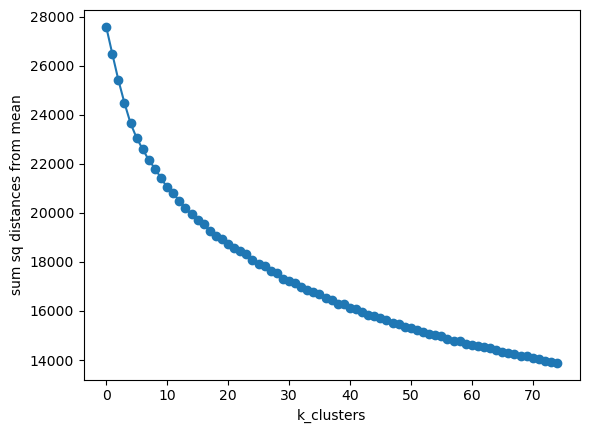

In [15]:
plt.clf()
plt.plot(cluster_errors, "o-")
plt.xlabel("k_clusters")
plt.ylabel("sum sq distances from mean")
plt.show()

In [16]:
## Generate the vectors!!! 

# df["category_mean_vectors"] = df["split_categories"]

In [ ]:
kmeans 

In [22]:
k = 30 # optimal k found in elbow plot
# kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
trimmed_df['kmean_clusters'] = y_pred

In [21]:
import joblib
# joblib.dump(kmeans, "kmeans_model.pkl")
kmeans = joblib.load("kmeans_model.pkl")

In [ ]:
np.save("X_reduced.npy", X_reduced)

In [20]:
X_reduced = np.load("X_reduced.npy")

In [ ]:
X_reduced.shape

## Plot the UMAP of the embeddings

In [26]:
from umap import UMAP

In [27]:
#### Count commas in the categories, this gives us the 

In [28]:
umap_embeddings = UMAP(n_neighbors=100, min_dist=0.3, n_components=2)

In [29]:
X_umap = umap_embeddings.fit_transform(X_reduced)


In [30]:
joblib.dump(umap_embeddings, "umap_model.pkl")

['umap_model.pkl']

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X)

In [11]:
# joblib.dump(tsne, "tsne_model.pkl")
tsne = joblib.load('tsne_model.pkl')

## Compare T-SNE and UMAP

In [13]:
import seaborn as sns

In [ ]:


# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], palette=palette)
plt.title('t-SNE without Labels')
plt.savefig("t-sne_arxvid.png")
plt.show()

In [ ]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], palette=palette)
plt.title('umap without Labels')
plt.savefig("umap_arxvid.png")
plt.show()

## Plot Clusters

In [ ]:
%matplotlib inline

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("cluster_tsne.png")
plt.show()

In [ ]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('umap with Kmeans Labels')
plt.savefig("cluster_umap_kmeans_labels.png")
plt.show()

In [14]:
import plotly.express as px
fig = px.scatter(trimmed_df, x=X_embedded[:,0], y=X_embedded[:,1], color=y_pred.astype(str),
                 hover_data=['id', 'title', 'categories_combined'],
                 height= 1000, width=1000,
                title = "t-SNE with Kmeans Labels")
fig.show()


ModuleNotFoundError: No module named 'plotly'

In [12]:
df["categories_combined"].head()

0                High Energy Physics - Phenomenology
1    Classical Analysis and ODEs Functional Analysis
2           General Relativity and Quantum Cosmology
3                                  Materials Science
4                                       Astrophysics
Name: categories_combined, dtype: object

In [17]:
trimmed_df["cat_embeddings"].dtype

dtype('O')

In [23]:
x_red_df = pd.Series(X_reduced.tolist(), dtype=object)

In [32]:
x_red_df = x_red_df.map(lambda x: str(x))

In [24]:
trimmed_df["cat_embeddings"] = x_red_df

In [26]:
# trimmed_df.head()

## Merge the embeddings with the original dataframe

In [5]:
df = pd.read_csv("df_merged_pca_embeds.csv")

/tmp/ipykernel_1139/3349443742.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_merged_pca_embeds.csv")


In [27]:
df.columns

Index(['id', 'title', 'year', 'authors', 'categories', 'abstract',
       'count_cats', 'split_categories', 'categories_combined'],
      dtype='object')

In [28]:
trimmed_df.columns

Index(['Unnamed: 0', 'id', 'title', 'year', 'authors', 'categories',
       'abstract', 'count_cats', 'split_categories', 'categories_combined',
       'cat_embeddings', 'kmean_clusters'],
      dtype='object')

In [38]:
df["categories_combined"].head()

0                High Energy Physics - Phenomenology
1    Classical Analysis and ODEs Functional Analysis
2           General Relativity and Quantum Cosmology
3                                  Materials Science
4                                       Astrophysics
Name: categories_combined, dtype: object

In [37]:
trimmed_df["categories_combined"].head()

0                High Energy Physics - Phenomenology
1    Classical Analysis and ODEs Functional Analysis
2           General Relativity and Quantum Cosmology
3                                  Materials Science
4                                       Astrophysics
Name: categories_combined, dtype: object

In [39]:
df_merged = pd.merge(df, trimmed_df[["categories_combined", "cat_embeddings", "kmean_clusters"]], how='inner', on=["categories_combined"])

In [42]:
df_merged.columns

Index(['id', 'title', 'year', 'authors', 'categories', 'abstract',
       'count_cats', 'split_categories', 'categories_combined',
       'cat_embeddings', 'kmean_clusters'],
      dtype='object')

In [30]:
null_df_merged = df_merged[df_merged["cat_embeddings"].isnull()]

In [41]:
len(df_merged)

717410

In [57]:
# null_df_merged.head()

In [32]:
# df_merged = df[~df_merged["cat_embeddings"].isnull()]

In [33]:
len(df_merged)

717410

In [43]:
df_merged.to_csv("df_merged_pca_embeds.csv", index=False)